In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy.sparse import csc_matrix
import os
import math

*Counts and UMIs are used here interchangeably. Same thing with barcodes and droplets*

## Samples Preparation

We firs list all necessary files for creating anndata objects for each sample. All relevant files have the ``gz`` extension:

In [2]:
raw_files = sorted([os.path.abspath("..") + f"/{i}" for i in os.listdir("..") if "gz" in i])

In [3]:
len(raw_files)/3

75.0

In this study, there are **75 samples in total**. There are three files per sample: ``barcodes.tsv``, ``genes.tsv`` and ``matrix.mtx``. We sorted our ``raw_files`` list as we want these files to be grouped together according to the corresponding sample, which will simplify the process of creating the **anndata** objects. We will group all three files per sample and store them in a new list:

In [4]:
raw_adatas = [raw_files[i:i+3] for i in range(0, len(raw_files), 3)]

Now we will write a wraper function to read the three files from each sample and create an **anndata** object for the sample. **Barcodes** and **genes** information will be stored inside the ``obs`` and ``var`` attributes repectively, which we will set by adding ``obs_names`` and ``var_names``. We will also add columns that will describe our **samples** insde the ``obs`` attribute using the information displayed in the sample name, whcih will come in handy once we merge our datasets:

In [5]:
def read_adata(adata_list):
    
    # We will use this to get sample, patient and dx information (dx is diagnosis)
    file_name = os.path.basename(adata_list[0])
    _, patient, dx, _, _= file_name.split("_")
    
    # The thrid file in the sublist is the mtx file
    adata = sc.read_mtx(adata_list[2]).T
    # The first the barcodes.tsv file
    barcodes_file = pd.read_csv(adata_list[0], header = None).iloc[:,0]
    # The third the genes.tsv file
    genes_file = pd.read_csv(adata_list[1], sep = "\t", header = None)

    # Variables
    adata.var_names = genes_file.iloc[:,1]
    adata.var["gene_id"] = genes_file.iloc[:,0].values
    adata.var["mt"] = adata.var_names.str.startswith('MT-') # Add boolean values
    adata.var["ribo"] = adata.var_names.str.startswith("RPS", "RPL") # Add boolean values
    adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]") # Add boolean values

    # Observations
    adata.obs_names = barcodes_file
    adata.obs["sample"] = f"{patient}_{dx}"
    adata.obs["patient"] = patient
    adata.obs["dx"] = dx
    return adata

We also defined genes (**mitochondrial**, **ribosomal** and **hemoglobin**) that we will use as covariates for estimating quality metrics, which we will explain later in the **quality control section**. Since the anndatas are quite large, and there is no enough memory, we will subset our samples to the first ten. Let's read our data and store each ``anndata`` from each sample inside a list called ``adatas``:

In [6]:
subset = raw_adatas[0:2]
adatas = [read_adata(i) for i in subset]

The object above is a view object. Use ``.copy`` to get the actual data.

## Quality Control

### Empty droplets
Before filtering low quality cells and removing doublets, it is necessary to do an estimation of droplets that do not contain cells. Tipically empty droplets contain counts, as background RNA is usually present in the original solution and is a form of contamination. Therefore, we need to calculate which barcodes do not actual contain cells and whose counts are the result of ambient RNA. We will use the ``DropletUtils`` package from Bioconductor for this purpose.

It is a good idea to calculate the quality metrics first, since they will give us the total counts per cell, as well as the percentage of mitochondrial gene counts, which we will later use to filter low quality cells. We will call the ``pp.calculate_qc_metrics()`` function from ``scanpy`` or our adatats:

In [7]:
# First calculate some metrics that will give us an estimation of the UMI counts per barcode
for adata in adatas:
    sc.pp.calculate_qc_metrics(adata, inplace=True, qc_vars=["mt", "ribo", "hb"], percent_top=[20], log1p=True) # log1p=log(1+x)

Let's visualize the total UMI counts for each barcode against the barcodes ranked from highest to lowest UMI counts. This will give us an idea of the quality of our dataset and the presence of background counts (likely empty droplets).

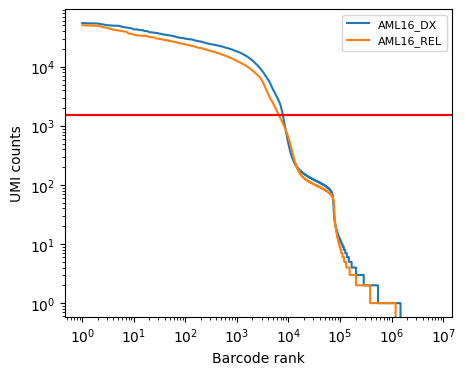

In [8]:
# Set figure and number of axes
fig, ax = plt.subplots(figsize=(5, 4))

# Conver array to one dimension to easyly iterate

for adata in adatas:
    # Prepare ranks and total counts
    total_counts = adata.obs["total_counts"].sort_values(ascending=False)
    ranks = range(1, len(total_counts) + 1)

    # Plot ranks vs total_counts
    ax.loglog(ranks, total_counts, label=adata.obs["sample"].iloc[0]) # This is in log10 scale, it gives almost the same information as log(1+x) or log(x), you can change the base
    ax.axhline(1500, 0,1, color='red')
    ax.set_xlabel("Barcode rank")
    ax.set_ylabel("UMI counts")
    ax.legend(loc="upper right", fontsize="8")

We can see **knee plots** characteristic of high quality samples, with both a 'cliff' and a 'knee' (view cell ranger [rank plot](https://www.10xgenomics.com/support/software/cell-ranger/latest/advanced/cr-barcode-rank-plot)). Note that ``DropletUtils`` calls 'knee' what cell ranger calls 'cliff'. The 'cliff' is the sharp transition between well caputerd cells and poor captured cells, background noise (e.g. ambient RNA) or even cell types with very low RNA content (e.g. represented in the small plateau). The 'knee' represents the second inflection point where there are not valid barcodes anymore, no biological variation can be inferred from these barcodes. For more info and a comment on transpossing this plot check [Lior Pachter's blog](https://liorpachter.wordpress.com/tag/knee-plot/).

Now prepare the raw data, which we will input into our R session and the ``EmptyDrops`` function from the ``DropletsUtils`` package, and from which we will obtain the first version of the filtered dataset as output. For this, we will use the original ``genes.tsv``, ``barcodes.tsv`` and ``matrix.mtx`` files from our directory, instead of using the ``adatas`` list. This way we will save a lot of space in memory.

We will proceed with our **R session**. We will take advantage of interoperability between languages so that we can use tools from R and Python, therefore being able to have full access the libraries from both platforms. For this, we are going to install the ``rpy2`` package and use it for our R session. And to be able to load anndata into R, we are going to use the ``anndata2ri`` package. Load the R environment as follows:

In [9]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/tmp/ipykernel_435/3659631106.py:9: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Let's initiate *R*, load ``DropletUtils`` amd run ``EmptyDrops``. ``EmptyDrops`` estimates the ambient RNA from the droplests and creates a pool of RNAs, upon which a number of Monte Carlo simulations will be performed, and *p-values* will be computed. The Limited field in the output indicates whether a lower p-value could be obtained by increasing niters. If any non-significant barcodes are ``TRUE`` for ``Limited``, we may need to increase the number of iterations. A larger number of iterations will result in a lower p-value for these barcodes, which may allow them to be detected after correcting for multiple testing (from the [Bioconductor tutorial](https://bioconductor.org/books/3.14/OSCA.advanced/droplet-processing.html)). We will ceate a function in **R** using the ``%%R`` magic:

In [10]:
%%R -i subset

suppressMessages(library(Matrix))
suppressMessages(library(DropletUtils))

empty_drops = function(subset){

    # Read .mtx file
    feat_mat = readMM(subset[3])

    # Read .tsv files
    genes = read.table(subset[2], sep = "\t", header = FALSE)
    barcodes = read.table(subset[1], sep = "\t", header = FALSE)
    
    # Add the appropiate rownames and column names to the sparse matrix
    rownames(feat_mat) = genes[,2]
    colnames(feat_mat) = barcodes[,1]
    
    # Call emptyDrops
    e.out = emptyDrops(feat_mat, test.ambient=FALSE)
    print(subset[3])
    print(summary(e.out$FDR <= 0.001))
    print(table(Sig=e.out$FDR <= 0.001, Limited=e.out$Limited))

    empty_out = e.out$FDR <= 0.001
    return(empty_out)
}


The **R session** above will give us a vector for the corresponding sample containing boolean values according to a FDR(false discovery rate )-adjusted p-value of 0.001 or less, that is, we call cells at a FDR of 0.1%, meaning that no more than 0.1% of our called barcodes should be empty droplets on average.
Let's get each vector from the outputed dictionary, and transfrom them using ``np.asarray``. This will result in am array with values ``0``, ``1`` and ``-2147483648`` for ``FALSE``, ``TRUE`` and ``NA``, which we will use to filter our anndatas.

Let's now create a new function in **Python** to call our ``empty_drops`` function on each ``anndata`` in our list and filter out empty barcodes, taking into consideration the ``0``, ``1`` and ``-2147483648`` conversions:

In [11]:
def valid_drops(adata, subset):
    %R -i subset -o empty_out empty_out = empty_drops(subset)
    to_filt = np.array(empty_out) == 1 # We want to keep values that are true
    adata = adata[to_filt]
    return adata

And call the function on our list:

In [12]:
adatas = [valid_drops(adata, sub) for adata,sub in zip(adatas,subset)]

[1] "/home/fernando/scanpy_scRNA-seq/GSM7494257_AML16_DX_raw_matrix.mtx.gz"
   Mode   FALSE    TRUE    NA's 
logical   39229    8337 6747314 
       Limited
Sig     FALSE  TRUE
  FALSE 39229     0
  TRUE      0  8337
[1] "/home/fernando/scanpy_scRNA-seq/GSM7494258_AML16_REL_raw_matrix.mtx.gz"
   Mode   FALSE    TRUE    NA's 
logical   26379    6211 6762290 
       Limited
Sig     FALSE  TRUE
  FALSE 26379     0
  TRUE      6  6205


**Looks like most of the barcodes are empty droplests**. The ambient RNA pool is estimated based on barcodes with UMI counts less or equal to the ``lower`` parameter from ``EmptyDrops``, which by default is ``100``. Bear in mind that it doesn't seem like there is an ideal or right ``lower`` value, and it highly depends on things such as the sequencing depth. ``EmptyDrops`` assumes that barcodes with low total UMI counts are empty droplets, a good test for how well the ``lower`` value adjusts for our data is to plot an histogram of the estimated *p-values* (not the Monte Carlo *p-values*), which should be close to uniform. For this we would need to set ``test.ambient=TRUE``, which will return the *p-values* for each cell (this might not be explained correctly, see [Bioconductor](https://bioconductor.org/books/3.18/OSCA.advanced/droplet-processing.html#qc-dropletshttps://bioconductor.org/books/3.18/OSCA.advanced/droplet-processing.html#qc-droplets) and 'Handling overdispersion' from the ``DropletUtils`` manual). This takes an enternity, so we are going to ignore it for now.

It is necessary to consider that that some variables appear more than once which can lead to errors or unintended behavior for downstream analysis tasks. We execute the proposed function var_names_make_unique() which makes the variable name unique by appending a number string to each duplicate index element: ‘1’, ‘2’, etc (from [the Single Cell Best Practices book](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html).

In [13]:
for adata in adatas:
    adata.var_names_make_unique()

/home/fernando/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/fernando/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### Low quality cells
To remove outliers or low quality cells, we will use [the Median Absotulte Deviation](https://medium.com/@pavanreddy1828/unveiling-the-power-of-median-absolute-deviation-a-guide-to-understanding-data-spread-9a823e174457). The MAD method for assessing dispersion is very robust against outliers, if we compare it with the standard deviation or the mean aboslute deviation. We will set cells as low quality if they differ by *x* number of MADs away from the median. Common tresholds are x=3 to x=5.

We will use these three covariates to filter our dataset:
1. The number of counts per barcode (count depth)
2. The number of genes per barcode
3. The fraction of counts from mitochondrial genes per barcode

We choose these 3 covariates as they are symptoms of cells with broken membranes whose cytoplasmic mRNA has leaked out and therefore only the mRNA in the mitochondria is still present. We will take into account all these covariates.

Since we already calculated the quality metrics abovee, let's do some data exploration by plotting some significant metrics. We will create a function to plot the ``pct_counts_mt`` using a scatter, as there seems to be a problem with subplots with several axes and the scatterplot function from scanpy (the color bar does not display correctly):

In [14]:
def scatter_plot(adata, axe, fig, xvar="total_counts", yvar="n_genes_by_counts", colby="pct_counts_mt"):
    # We sort the mt counts as we want to bring to the front the hightest pc_counts_mt points, colored by hue
    plot = sns.scatterplot(x=xvar, y=yvar, data=adata.obs.sort_values(colby), ax=axe, hue=colby, palette="viridis", size=0.1, linewidth=0)
    norm = plt.Normalize(adata.obs[colby].min(), adata.obs[colby].max()) # To add color bar
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm) # To add color bar
    sm.set_array([]) # To add color bar
    plot.get_legend().remove() # To add color bar
    colorbar = fig.colorbar(sm, ax=axe) # To add color bar
    return plt, colorbar

Let's also create a function to plot some relevant metrics:

In [163]:
def violin_dis_plot(adatas, var1="total_counts", var2="sample", var3="pct_counts_in_top_20_genes", hue=None, sort=False):
    # Create a dataframe cocatenating each sample for some of the plots
    df = pd.concat([adata.obs for adata in adatas])

    # Set figure and number of axes (/3 cause we have 3 columns)
    n_rows = math.ceil(len(adatas)/3) # This will always round up (Python round() round to the nearest even number)
    
    fig, axs = plt.subplots(1+n_rows,3, figsize=(12, 7)) # Add + 1 as we the first row is taken by the violin and density distribution plot (first three axes)
    # Add some extra space between plots
    fig.subplots_adjust(hspace=0.3)
    
    # Conver array to one dimension to easyly iterate
    axs = axs.flat # We will always have more than one row so is ok to do this
    
    sns.set(font_scale=0.6)

    if sort == True:
        df = df.sort_values(hue)

    if hue != None:
        palette = "hls"
    else:
        palette = None

    sns.violinplot(x=var2, y=var1, data=df, ax=axs[0])
    sns.stripplot(x=var2, y=var1, data=df, size=2, jitter=0.1, hue=hue, ax=axs[0], palette=palette)

    # Plot probability distributions
    sns.kdeplot(df, x=var1, hue=var2, ax=axs[1])
    sns.kdeplot(df, x=var3, hue=var2, ax=axs[2])

    for ax in axs[3:]:
        ax.axis("off")
    for adata,ax in zip(adatas,axs[3:]):
        ax.axis("on")
        scatter_plot(adata, ax, fig)
        ax.set_title(adata.obs["sample"].iloc[0])

And now we can plot:

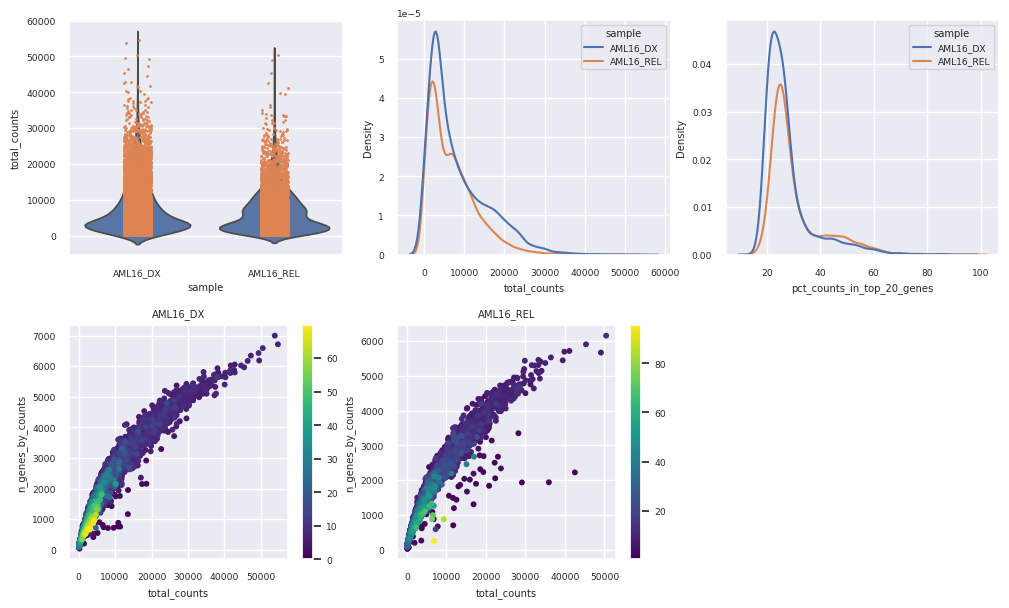

In [164]:
violin_dis_plot(adatas)

We can also use ridge plots for density distributions which are quite usefull wen we have several samples. Might be a good idea to concatenate **observations** dataframes to faciliate plotting per sample:

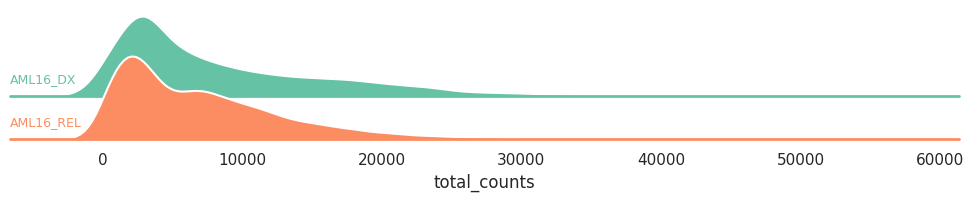

In [18]:
df1 = pd.concat([adata.obs for adata in adatas])

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})

palette = sns.color_palette("Set2", 12)

g = sns.FacetGrid(df1, palette=palette, row="sample", hue="sample", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x="total_counts", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="total_counts", color="white")

g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
#g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color=color, fontsize=9,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "sample")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="total_counts")
#g.despine(left=True)
g.despine(bottom=True, left=True)
#plt.suptitle('Total Counts Density', y=0.98)

We can see from the **probability distributions** that most top 20 genes represent between 20% to 30% of the total counts for most barcodes. This is very significant since cells have thousand of genes. In some of the samples there are a high number of barcides with high counts for the top 20 genes with regards to the total. *This might be the result of heterogenous cell populations?*.

There also semms to be a postive log relationship between the number of total counts and the number of genes, which seems quite reasonable.

Why are there still barcodes with low counts? This is probably due to the fact that ``EmptyDrops`` uses the ambient profile to look for signigicant barcodes by comparing it to the RNA content of said barcodes. If a barcode has 0 counts, then it is obvious that its ambient RNA content won't be significant. Either way, it seems that barcodes with counts below ``lower`` were removed (in this case ``lower=100``).

We can also see that some barcodes have high percentage of mitochondrial counts, **up to 60%-80% of the total counts**. Looks like a significant amount of these barcodes are associated with low total UMI counts, which could mean that they are are low quality cells (with a signigicant content of ambient RNA), and not cells with, say, high energy demands.

Let's create a function to remove outliers according to a specific column based on the quality metrics from our **obervations**. We will use the MADs method to remove low quality cells.

In [19]:
import scipy.stats as sts

def is_outlier(adata, metric: str, mads: int):
    column = adata.obs[metric]
    mad = sts.median_abs_deviation(column)
    outlier = (column < np.median(column) - mads*mad) | (column > np.median(column) + mads*mad) # | is an or operator equivalent for array like data or pandas dataframes
    return outlier

Let's indentify outliers based on three common covariates that are symptons of low quality cells: ``total_counts``, ``n_genes_by_counts`` and ``pct_counts_in_top_20_genes``, based on 5 MADs of distance from the median:

In [20]:
for adata in adatas:
    adata.obs["outlier"] = is_outlier(adata, "log1p_total_counts", 5) | is_outlier(adata, "log1p_n_genes_by_counts", 5) | is_outlier(adata, "pct_counts_in_top_20_genes", 5)

Why apply the treshold to log-transformed data? A log-transformation is used to improve resolution at small values and to avoid negative thresholds that would be meaningless for a non-negative metric. Furthermore, it is not uncommon for the distribution of library sizes to exhibit a heavy right tail; the log-transformation avoids inflation of the MAD in a manner that might compromise outlier detection on the left tail. (More generally, it makes the distribution seem more normal to justify the 99% rationale mentioned above.) The function will also do the same for the log-transformed number of expressed genes (view [Bioconductor](https://bioconductor.org/books/3.13/OSCA.basic/quality-control.html)).

Let's plot our counts to see how our data changes after filtering. We will create a function for this purpose:

In [32]:
def plot_filt_unfilt(adata):
    # Create dataframes for easy plotting
    df_filt = adata.obs[adata.obs["outlier"] == False].copy()
    df_unfilt = adata.obs
    # Add column for concatenation
    df_filt["filter"] = "filtered"
    df_unfilt["filter"] = "unfiltered"
    # And concatenate
    df = pd.concat([df_filt, df_unfilt])
    df.reset_index(drop=True, inplace=True) #This is necessary for some reason. This will reset the index of df and drop the old index, ensuring that the index is unique and starts from 0 (ask chatgpt) 
    
    # Violin plot filtered vs unfiltered
    fig, ax = plt.subplots(2, 2 , figsize=(12, 10))
    #plt7 = sc.pl.violin(adata, "log1p_total_counts", ax = ax[0], show = False) # show = False is required for some reason
    sns.violinplot(y="total_counts", data=df, x="filter", ax=ax[0,0])
    sns.stripplot(y="total_counts", data=df.sort_values("outlier"), x="filter", hue="outlier", jitter=0.2, ax=ax[0,0])
    ax[0,0].set_ylim(0, 200)

    # Plot histogram of unfiltered and filtered values
    # Filtered
    ax[0,1].hist(df_filt["total_counts"], bins = 100)
    ax[0,1].set_xlabel("total_counts")
    ax[0,1].set_ylabel("frequency")
    ax[0,1].set_title(df_filt["sample"].iloc[0]+ " - Filtered")
    # Unfiltered
    ax[1,0].hist(df_unfilt["total_counts"], bins = 100)
    ax[1,0].set_xlabel("total_counts")
    ax[1,0].set_ylabel("frequency")
    ax[1,0].set_title(df_unfilt["sample"].iloc[0] + " - Unfiltered")
    ax[1,1].axis("off")
    
    #return fig, ax, plot1, plot2, plot3, plot4, plot5, plot6
    #plt8 = sc.pl.violin(adata[adata.obs["outlier"] == False], "total_counts", 


Notice that in the function we zoomed in the viollin plot, otherwise differences were hard to see. Change ``ax.set_ylim()`` accordingly. And we plot:

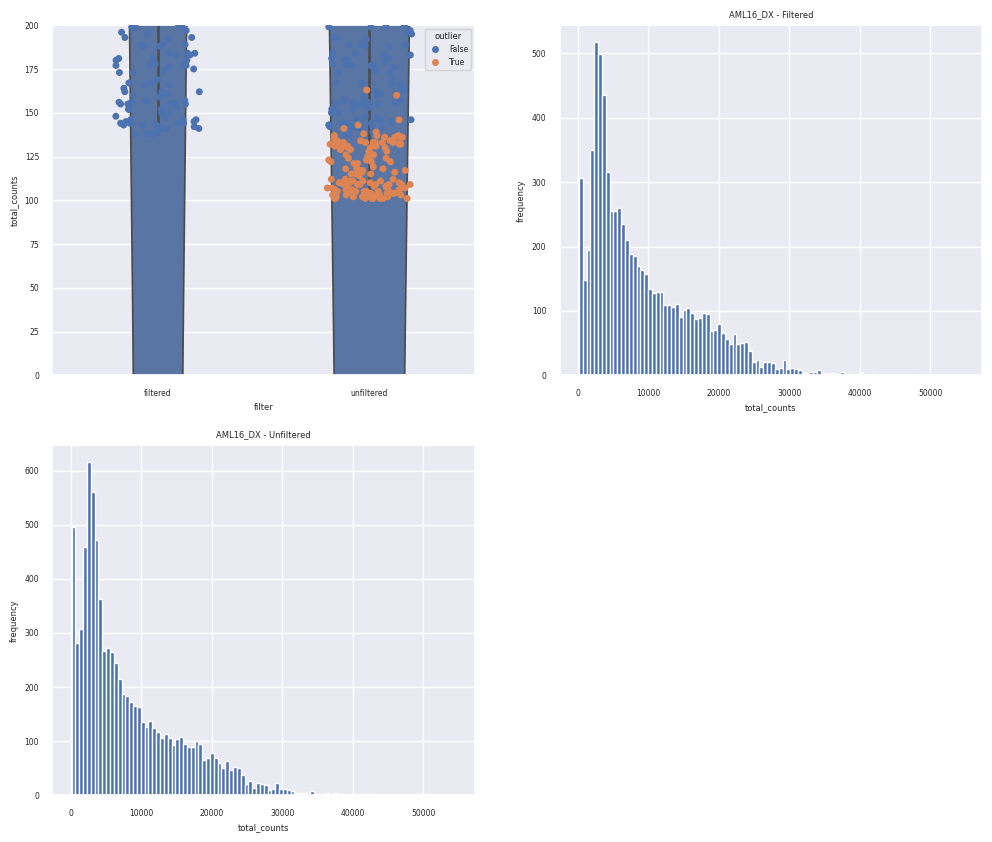

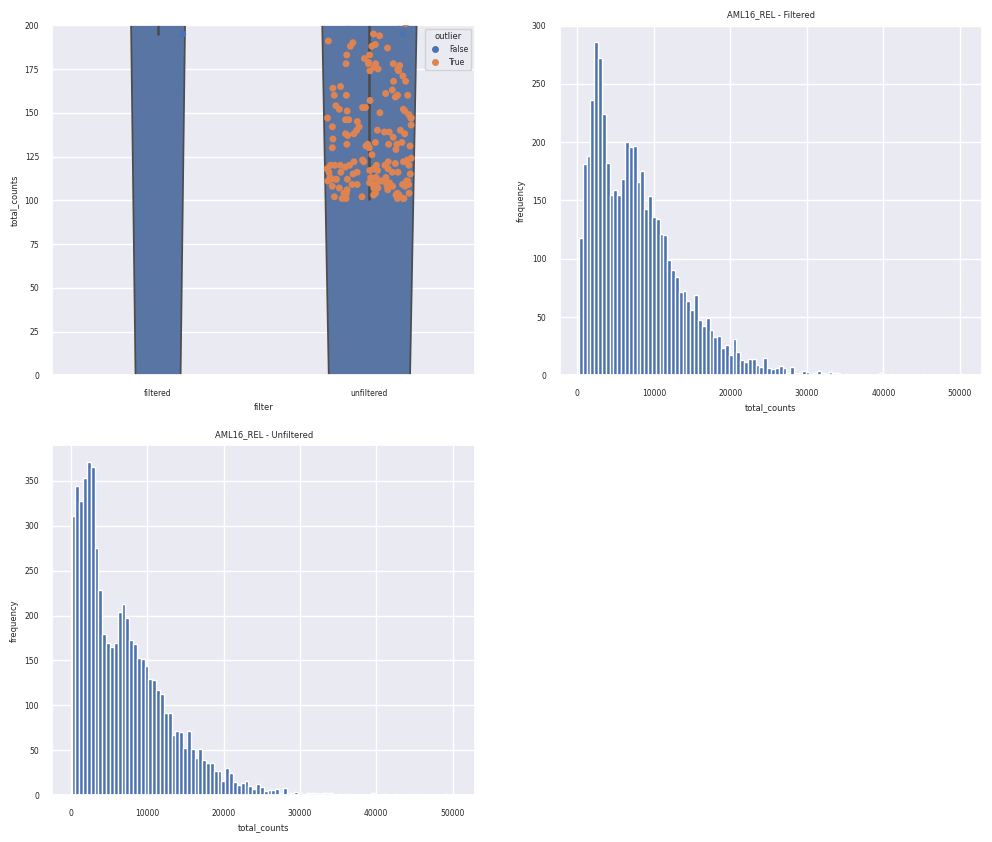

In [33]:
for adata in adatas:
    plot_filt_unfilt(adata)

#### Percentage of mitochondrial counts

Now let's filter low quality barcides based on **3 MADs and cells with a percentage of mitochondrial RNA higher than 8%**. The treshold for filtering should vary depending on the cell and tissue type, and high percentages might represent true biological variation. For instance, cells with higher energy demands might have a significant fraction of mitcohondrial UMIs with respect to the total, such as cardiomiocytes, with up to **30% of the total mRNA belonging to mitochondrial RNA** (view [paper](https://www.cell.com/molecular-therapy-family/methods/fulltext/S2329-0501(18)30066-4?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS2329050118300664%3Fshowall%3Dtrue)).

We will use the ``is_outlier`` function using the MAD in addition to the 8% treshold to add a new "mt_outlier" column with boolean values which we will use later for filtering:

In [35]:
for adata in adatas:
    mt_outliers = is_outlier(adata, "pct_counts_mt", 3)
    adata.obs["mt_outlier"] = mt_outliers | (adata.obs["pct_counts_mt"] > 8)

Let's plot also the total counts vs percentage of mitochondrial counts, coloring by the ``"mt_outlier"`` field. This will give as a better idea of the relationship between the total counts and the ambient mRNA fraction. But first let's create a function:

In [110]:
def scatter_plot_mt(adatas):
    n_rows = math.ceil(len(adatas)/3) # Again, number of rows according to three column

    fig, axs = plt.subplots(n_rows, 3, figsize=(12, 4))

    if len(np.shape(axs)) > 1: # If axs is not  unidimensional(nrows>1)
        axs = axs.flat
    
    for ax in axs:
        ax.axis("off")
    
    for adata,ax in zip(adatas,axs):
        ax.axis("on")
        sns.scatterplot(x="total_counts", y="pct_counts_mt", data=adata.obs.sort_values("mt_outlier"), ax=ax, hue="mt_outlier", linewidth=0, size=2)
        handles, labels = ax.get_legend_handles_labels() # very ugly fix, look for another solution
        ax.legend(handles[0:2], labels[0:2], fontsize="8")
        ax.set_title(adata.obs["sample"].iloc[0])

And plot:

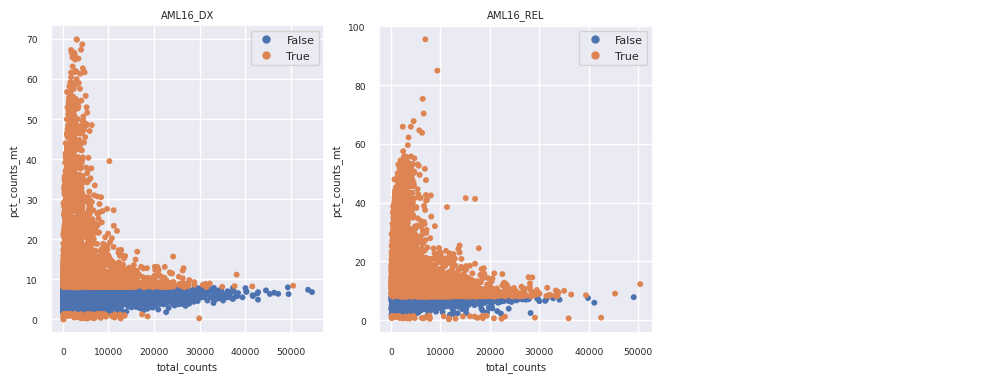

In [111]:
scatter_plot_mt(adatas)

Looks like a lot of cells are going to be discared. Maybe be less stringent in terms of quality? Other than that it looks like there is a clear relationship betweem the low number of counts and high percentage of mitochondrial RNA. These are probably droplets with low quality cells whose mtRNA has been leaked from their content.

Now we are going to combine both ``outlier`` and ``mt_outlier`` information into a single column. These are going to be the cells that passed the metrics:

In [138]:
for adata in adatas:
    adata.obs["passed"] = (~adata.obs["outlier"]) & (~adata.obs["mt_outlier"]) # use "~" to call False values, which are the valid values (we don't want ouliers)

Here, the ``&`` indicates that for barcode to be qualified for further downstream analysis, it needs to satify the treholds of both ``outlier`` and ``mt_outlier`` quality metrics. The rest will be discared.

And plot again using ``violin_dis_plot`` to see the differences betweem filtered amd unfiltered ``anndatas``:

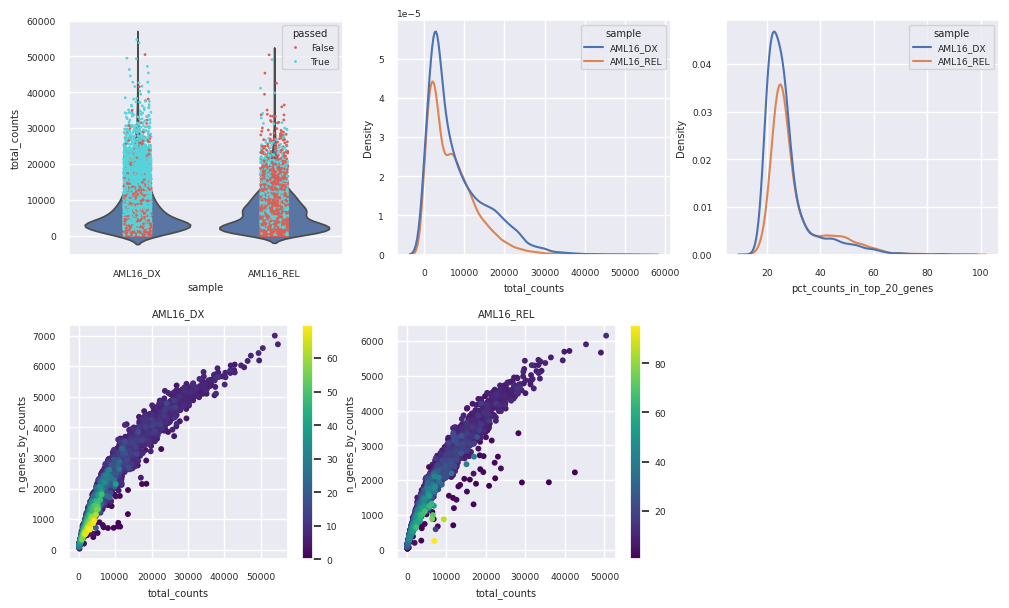

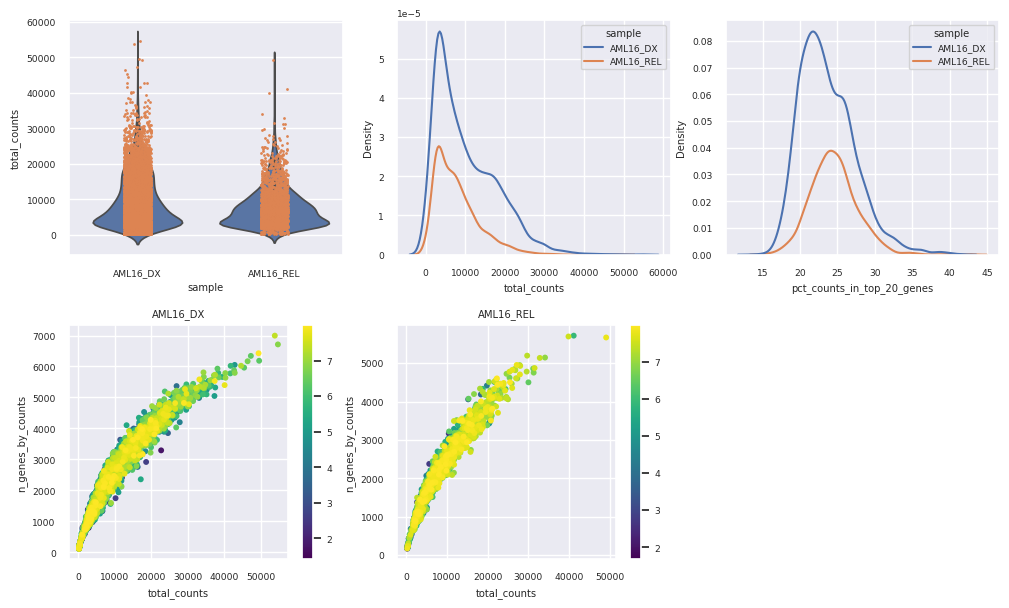

In [165]:
violin_dis_plot(adatas, hue="passed")
violin_dis_plot([adata[adata.obs["passed"]] for adata in adatas])

We  can see from the density plots that the total counts resemble a negative binomial distribution. We can also see what seem to be two probability distributions for each sample, maybe a symptom of population heterogeneity? **Is this true or well explained?**

Time to subset the data based on the criteria of cell outliers based on the three covariates described above:

In [166]:
adatas = [adata[adata.obs["passed"]] for adata in adatas]

Now we have the filtered dataset. Note that ``adata.obs[adata.obs["variate"]]`` is equivalent to ``adata[adata.obs.variate].obs``. Maybe we should plot some histograms.

### Removal of ambient RNA

It is also important to remove cell free RNA from the droplets, since they can bias the estimation of counts and they are considered as a form of contamination. Methods usually estimate ambient RNA using empty droplets. We will take advantage of interoperability between languages so that we can use tools from R and Python, and use the most appropiate libraries both platforms offer. For this, we are going to use again the ``rpy2``.

Before using ``SoupX`` for the removal of ambient RNA, it is necessary to first cluster cells. Why log transform the data? It seems that single cell methods for DE do not use GLM for fitting the data and estimating the coefficients (check [this](https://github.com/scverse/scanpy/issues/1364)). We will do a quick normalization, data transformation and clustering in order to estimate the ambient RNA, and explain later in more detail. We will create a new list from the ``adatas`` list since we will perfrom clustering  and normalization again. Let's prepare our data:

In [167]:
adatas_amb = [adata.copy() for adata in adatas]
for adata in adatas_amb:
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

We will perform a PCA for dimensionality reduction followed by clustering using the Leiden algorithm. We will add a new column to our ``obs`` with the cluster group for each cell called ``soupx_groups``:

In [168]:
#!pip3 install igraph
#!pip3 install leidenalg
for adata in adatas_amb:
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata, key_added="soupx_groups")

/tmp/ipykernel_435/1962490550.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added="soupx_groups")


Let's check the clusters and save the information in a new variable, which we will use later as input for ``SoupX``:

In [169]:
soupx_groups = [adata.obs["soupx_groups"] for adata in adatas_amb]

We can add the groups to our original adata, which will come in handy later on:

In [170]:
for adata, gr in zip(adatas, soupx_groups):
    adata.obs["soupx_groups"] = gr

/tmp/ipykernel_435/272882583.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["soupx_groups"] = gr
/tmp/ipykernel_435/272882583.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["soupx_groups"] = gr


We can now remove our normalized and transformed ``adata_subset2`` to free memory:

In [171]:
del adatas_amb

``SoupX`` requires raw data and filtered data with all droplets coatining cells. We need to prepare our filtered data to parse it to R. We will extract the sprase matrix, column and row names of each adata and store them inside a list.

Now let's run ``SpoupX``:

In [172]:
%%R

suppressMessages(library(SoupX))
suppressMessages(library(Matrix))

make_soup = function(raw_files, genes, barcodes, filt_data, soupx_groups){

    # First load unfiltered data
    # Read .mtx file
    tod = readMM(raw_files[3])

    # Read .tsv files
    raw_barcodes = read.table(raw_files[1], sep = "\t", header = FALSE)
    # Add the appropiate rownames and column names to the sparse matrix
    rownames(tod) = genes
    colnames(tod) = raw_barcodes[,1]

    # Prepare filtered data
    toc = as(filt_data, "sparseMatrix")
    rownames(toc) = genes
    colnames(toc) = barcodes

    # Run SoupX
    sc = SoupChannel(tod, toc, calcSoupProfile = FALSE)
    print("Calculate soup profile")
    soupProf = data.frame(row.names = rownames(toc), est = rowSums(toc)/sum(toc), counts = rowSums(toc))
    sc = setSoupProfile(sc, soupProf)
    print("Set clusters")
    sc = setClusters(sc, soupx_groups)
    print("Estimate contamination fraction")
    sc  = autoEstCont(sc, doPlot=FALSE)
    print("Infer corrected table of counts and rount to integer")
    out = adjustCounts(sc, roundToInt = TRUE)

    return(out)
}


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

If we want to use **R** and python in the same cell, we will have to use the ``%R`` magic oneliner. The output ``-o out`` will be a **sparse matrix** with the modified **ambient filtered counts**:

In [174]:
for adata, raw_files in zip(adatas, subset):
    soupx_groups = adata.obs["soupx_groups"]
    filt_data = adata.X.T
    barcodes = adata.obs_names
    genes = adata.var_names
    
    %R -i raw_files -i genes -i barcodes -i filt_data -i soupx_groups -o out out = make_soup(raw_files, genes, barcodes, filt_data, soupx_groups)
    
    adata.layers["raw_counts"] = adata.X # We wamt to keep the pre ambient filtered counts
    adata.layers["soupx_counts"] = out.T # Remember that most R packages need a transposed matrix with repect to scanpy
    adata.X = adata.layers["soupx_counts"] # We want our filtered counts to be the default counts

[1] "Calculate soup profile"
[1] "Set clusters"
[1] "Estimate contamination fraction"
[1] "Infer corrected table of counts and rount to integer"


911 genes passed tf-idf cut-off and 101 soup quantile filter.  Taking the top 100.
Using 1089 independent estimates of rho.
Estimated global rho of 0.03
Expanding counts from 19 clusters to 5387 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


[1] "Calculate soup profile"
[1] "Set clusters"
[1] "Estimate contamination fraction"
[1] "Infer corrected table of counts and rount to integer"


450 genes passed tf-idf cut-off and 119 soup quantile filter.  Taking the top 100.
Using 843 independent estimates of rho.
Estimated global rho of 0.03
Expanding counts from 14 clusters to 2136 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


Finally, since we are not going to make more modifications on the counts with regards to filtering, we can remove those genes with very low read counts since they are not very informative and will make computation more efficient. We will finlter genes that are not present in at least 20 cells:

In [193]:
for adata in adatas:
    sc.pp.filter_genes(adata, min_cells=20)

### Removal of Doublets

Doublets are defined as two cells that are sequenced under the same cellular barcode, for example, if they were captured in the same droplet (from the [single-cell best practices book](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html#correction-of-ambient-rna)). We are going to focus on the removal of **heterotypic doublets**. Heterotypic doublets are doublets which are comprised of cells of different types, contrary to homotypic doublets, which only contain one cell type. The reason why we ignore homotypic doublets is that they usually cannot be indiefied and are considered relatively inocous for most downstream analysis, although they can be indentified using cell hashing or SNP. Heterotypic doublets, instead, can appear as an artifactual novel cell type and disrupt downstream analyses (view [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9204188/)).

We will use ``scDblFinder`` for idenfied doublets as it was found to give the best overal performance among different indentification methods (view [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8339294/)). ``scDblFinder`` creates artificial doublets at random or between clusters, then  new PCA is performed on the combination of real and artificial cells, from which a kNN network is generated which is then  used to distinguish doublets (either artificial or given) from other cells, and assigns a score on this basis.

There are two approaches for doublet generation. The cluster-based approach and random approach perform very similarly, although if the data is very cleary segregated into clusters of if you are iterested in the origin of doublets the first is preferable (check [snippet](https://bioconductor.org/packages/devel/bioc/vignettes/scDblFinder/inst/doc/scDblFinder.html)). We will use the random approach since is the less computationally expensive (**maybe**) and the default approach.

Again, we will have to use the ``rpy2`` package as ``scDblFinder`` is a Bioconductor package. We are interested in the ``class`` output, which will give us the barcodes type (singlet, doublet) and the ``score``. We won't do any filtering, we will just keep the info in new column, as they might be useful during visualization.

In [194]:
%%R

suppressMessages(library(scDblFinder))

db_finder = function(feat_matrix){
    sce = scDblFinder(feat_matrix)
    db_score = sce$scDblFinder.score
    db_class = sce$scDblFinder.class
    return(list(db_score, db_class))
}

In [195]:
for adata in adatas:
    feat_matrix = adata.X.T
    %R -i feat_matrix -o db_out db_out = db_finder(feat_matrix)
    db_score, db_class = [values for keys, values in db_out.items()]
    adata.obs["scDblFinder_score"] = db_score
    adata.obs["scDblFinder_class"] = db_class

Assuming the input to be a matrix of counts or expected counts.
Creating ~4310 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 573 cells excluded from training.
iter=1, 577 cells excluded from training.
iter=2, 569 cells excluded from training.
Threshold found:0.362
477 (8.9%) doublets called
In addition: Warning message:
In .checkSCE(sce) :
  Some cells in `sce` have an extremely low read counts; note that these could trigger errors and might best be filtered out


Assuming the input to be a matrix of counts or expected counts.
Creating ~1709 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 177 cells excluded from training.
iter=1, 176 cells excluded from training.
iter=2, 169 cells excluded from training.
Threshold found:0.486
117 (5.5%) doublets called


In [ ]:
del db_out

Now we can save our ``anndatas`` as ``.h5`` files for further processing:

In [197]:
for adata in adatas:
    sample = adata.obs["sample"].iloc[0]
    adata.write(os.path.abspath("..") + f"/{sample}_processed.h5ad")